## Twitter Dataset Prepare

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import tqdm
import regex
import os
import re
import shutil
import operator
import codecs
from time import time
import random
from math import log
from nltk import sent_tokenize
from pymystem3 import Mystem
from seaborn import heatmap
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import RussianStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV



from sklearn.ensemble import GradientBoostingClassifier
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

%matplotlib inline

База данных состоит из 12 столбцов:
- id: уникальный номер сообщения в системе twitter;
- tdate: дата публикации сообщения (твита);
- tmane: имя пользователя, опубликовавшего сообщение;
- ttext:  текст сообщения (твита);
- ttype: поле в котором в дальнейшем будет указано к кому классу относится твит (положительный, отрицательный, нейтральный);
- trep: количество реплаев к данному сообщению. В настоящий момент API твиттера не отдает эту информацию;
- trtf: число ретвитов
- tfav: число сколько раз данное сообщение было добавлено в избранное другими пользователями;
- tstcount: число всех сообщений пользователя в сети twitter;
- tfol: количество фоловеров пользователя (тех людей, которые читают пользователя);
- tfrien: количество друзей пользователя (те люди, которых читает пользователь);
- listcount: количество листов-подписок в которые добавлен твиттер-пользователь.

In [2]:
header = ['id', 'tdate', 'tmane', 'ttext', 'ttype', 'trep', 'trtf', 'tfav', 'tstcount', 'tfol', 'tfrien', 'listcount']

#### Загружаем положительные и негативные твиты в один DataFrame, после этого перемешиваем с помощью sample(frac=1)

In [3]:
pos_twitts = pd.read_csv('dataset/train_positive.csv', sep=';', names=header)
neg_twitts = pd.read_csv('dataset/train_negative.csv', sep=';', names=header)
twitts = pd.concat([pos_twitts, neg_twitts], axis=0)
twitts = twitts.sample(frac=1)

#### Смотрим размерность нашего размеченного датасета и проверяем, что у нас 2 вида твитов(положительные(1) и негативные(-1))

In [4]:
print twitts.shape
twitts.head()

(226834, 12)


,id,tdate,tmane,ttext,ttype,trep,trtf,tfav,tstcount,tfol,tfrien,listcount
44956,414395158952964096,1387634479,nesterovaa_,Бляя у них там весело:(\n Я как лох ебанный в ...,-1,0,0,0,549,10,9,0
28356,409613685238562817,1386494487,anutahimmel,"RT @angeljeka: Сегодня родился ""поющий кусок с...",1,0,2,0,12525,140,102,5
106752,424200872411660288,1389972343,vrotvamnogi3,"кажется, я проебала кольцо, и кажется, мне пиз...",-1,0,0,0,3861,27,29,0
22420,411857145806606336,1387029370,Zelenator,"Не проспать концерт беспризорников, не проспат...",-1,0,0,0,31043,569,291,26
21005,411675546373066752,1386986073,Kai_JiGoku,"Вспомнил, что после работы хотел в оптовку схо...",-1,0,0,0,6838,48,60,1


In [5]:
twitts.ttype.unique()

array([-1,  1], dtype=int64)

## Предобработка текста

In [6]:
X = twitts.ttext.values
y = twitts.ttype.values

In [7]:
def prepare_text(text):
    text = text.lower().strip()
    text = ' '.join(text.split())
    text = re.sub(r'@\S+', '', text) # delete @user_name
    text = re.sub(r'#\W+', '', text) # delete #hashtag
    text = re.sub(r'[\!\"\#\$\%\&\\\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\\\]\^\_\`\{\|\}\~, a-z, 0-9]+', ' ', text) # delete smiles
    return text

#### Отчитстка твитов от "мусора"

In [8]:
X_pr = [prepare_text(text).decode('utf-8').strip() for text in X]

#### Лемматизация с помощью mystem

In [9]:
file = codecs.open("raw.txt", "w", "utf-8")
for line in X_pr:
    file.write(line+'\n')
file.close()

In [10]:
%time os.system('mystem.exe raw.txt out.txt -dlc')

Wall time: 1min 12s


0

In [11]:
file = codecs.open("out.txt", "r", "utf-8")
X_sent = [line for line in file]
file.close()

In [12]:
X_mystem = [prepare_text(text).strip() for text in X_sent]

#### Удаление коротких слов и твитов

In [13]:
X_mystem_no_single = [' '.join([word.strip() for word in words.split() if len(word.strip())>1]) for words in X_mystem]

In [14]:
idx = [len(words.split()) > 4 for words in X_mystem_no_single]
X_mystem_no_single_no_short = np.array(X_mystem_no_single)[idx]
y_mystem_no_single_no_short = np.array(y)[idx]

### Разбиваем наш датасет с помощью train test split и создаем модели

In [15]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_mystem_no_single_no_short, y_mystem_no_single_no_short, test_size=0.3, random_state=42)

#### Логистическая регрессия

In [16]:
model_logreg = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                         ('log_reg', LogisticRegression(C=0.5))])
model_logreg_saga = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                         ('log_reg', LogisticRegression(max_iter=300, solver='saga'))])
model_logreg_tf_idf = Pipeline([('count', TfidfVectorizer(ngram_range=(1, 3), min_df=1)), 
                                ('log_reg', LogisticRegression())])

#### Наивный Байес

In [17]:
model_nbm = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('nb', MultinomialNB()),])
model_nbm_tfidf = Pipeline([('tf-idf', TfidfVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('nb', MultinomialNB()),])

In [18]:
model_nbb = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('nb', BernoulliNB()),])
model_nbb_tfidf = Pipeline([('tf-idf', TfidfVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('nb', BernoulliNB()),])

#### SVM

In [19]:
model_svm = Pipeline([('count', CountVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('svm', LinearSVC()),])
model_svm_tfidf = Pipeline([('tf-idf', TfidfVectorizer(ngram_range=(1, 3), min_df=1)), 
                     ('svm', LinearSVC()),])

### Обучение

In [20]:
%time model_logreg.fit(X_train, y_train)
%time model_logreg_saga.fit(X_train, y_train)
%time model_logreg_tf_idf.fit(X_train, y_train)
%time model_nbm.fit(X_train, y_train)
%time model_nbm_tfidf.fit(X_train, y_train)
%time model_nbb.fit(X_train, y_train)
%time model_nbb_tfidf.fit(X_train, y_train)
%time model_svm.fit(X_train, y_train)
%time model_svm_tfidf.fit(X_train, y_train)

Wall time: 37.4 s


C:\Users\Ivan\Anaconda2\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Wall time: 1min 33s
Wall time: 18.8 s
Wall time: 14.8 s
Wall time: 15.7 s
Wall time: 14.7 s
Wall time: 15.8 s
Wall time: 1min 12s
Wall time: 18.9 s


Pipeline(memory=None,
     steps=[('tf-idf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=Tr...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

#### Посмотрим у каких слов получились самые влиятельные веса и считаем оценки (смотрим модель логистической регрессии без TF-IDF)

In [21]:
words_logreg = model_logreg.steps[0][1].get_feature_names()
coefs_logreg = model_logreg.steps[1][1].coef_[0]

words_logreg_tf_idf = model_logreg_tf_idf.steps[0][1].get_feature_names()
coefs_logreg_tf_idf = model_logreg_tf_idf.steps[1][1].coef_[0]

In [22]:
model_coefs_logreg = pd.Series(index=words_logreg, data=coefs_logreg)
model_coefs_logreg_tf_idf = pd.Series(index=words_logreg_tf_idf, data=coefs_logreg_tf_idf)

In [23]:
model_coefs_logreg_sorted = model_coefs_logreg.sort_values()
model_coefs_logreg_tf_idf_sorted = model_coefs_logreg_tf_idf.sort_values()

In [24]:
print model_coefs_logreg_sorted[:5]
print model_coefs_logreg_sorted[-5:]

обидно     -2.897252
печально   -2.418762
грустно    -2.304525
печаль     -2.258247
жаль       -2.025424
dtype: float64
хах            1.854082
ржа            1.865648
не плохо       1.905000
не забывать    1.935209
не зря         1.974946
dtype: float64


### Предсказание по тестовой выборке

In [25]:
preds_logreg = model_logreg.predict(X_test)
preds_logreg_saga = model_logreg_saga.predict(X_test)
preds_logreg_tfidf = model_logreg_tf_idf.predict(X_test)

In [26]:
preds_nbm = model_nbm.predict(X_test)
preds_nbm_tfidf = model_nbm_tfidf.predict(X_test)

In [27]:
preds_nbb = model_nbb.predict(X_test)
preds_nbb_tfidf = model_nbb_tfidf.predict(X_test)

In [28]:
preds_svm = model_svm.predict(X_test)
preds_svm_tfidf = model_svm_tfidf.predict(X_test)

## Итоговые результаты

In [30]:
f1 = []
print "LogisticRegression: \n", classification_report(y_test, preds_logreg)
print precision_recall_fscore_support(y_test, preds_logreg, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test, preds_logreg, average='weighted')[2])

print "LogisticRegression with saga: \n", classification_report(y_test, preds_logreg_saga)
print precision_recall_fscore_support(y_test, preds_logreg_saga, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test, preds_logreg_saga, average='weighted')[2])

print "LogisticRegression with tf-idf: \n", classification_report(y_test, preds_logreg_tfidf)
print precision_recall_fscore_support(y_test, preds_logreg_tfidf, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test, preds_logreg_tfidf, average='weighted')[2])

print "MultinomialNB: \n", classification_report(y_test, preds_nbm)
print precision_recall_fscore_support(y_test, preds_nbm, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test, preds_nbm, average='weighted')[2])

print "MultinomialNB with tf-idf: \n", classification_report(y_test, preds_nbm_tfidf)
print precision_recall_fscore_support(y_test, preds_nbm_tfidf, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test, preds_nbm_tfidf, average='weighted')[2])

print "BernoulliNB: \n", classification_report(y_test, preds_nbb)
print precision_recall_fscore_support(y_test, preds_nbb, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test, preds_nbb, average='weighted')[2])

print "BernoulliNB with tf-idf: \n", classification_report(y_test, preds_nbb_tfidf)
print precision_recall_fscore_support(y_test, preds_nbb_tfidf, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test, preds_nbb_tfidf, average='weighted')[2])

print "SVM: \n", classification_report(y_test, preds_svm)
print precision_recall_fscore_support(y_test, preds_svm, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test, preds_svm, average='weighted')[2])

print "SVM with tf-idf: \n", classification_report(y_test, preds_svm_tfidf)
print precision_recall_fscore_support(y_test, preds_svm_tfidf, average='weighted')[2]
f1.append(precision_recall_fscore_support(y_test, preds_svm_tfidf, average='weighted')[2])

LogisticRegression: 
             precision    recall  f1-score   support

         -1       0.76      0.75      0.76     29707
          1       0.76      0.78      0.77     30552

avg / total       0.76      0.76      0.76     60259

0.762322282807
LogisticRegression with saga: 
             precision    recall  f1-score   support

         -1       0.76      0.75      0.76     29707
          1       0.76      0.77      0.77     30552

avg / total       0.76      0.76      0.76     60259

0.761791645113
LogisticRegression with tf-idf: 
             precision    recall  f1-score   support

         -1       0.74      0.77      0.75     29707
          1       0.76      0.73      0.75     30552

avg / total       0.75      0.75      0.75     60259

0.748857479689
MultinomialNB: 
             precision    recall  f1-score   support

         -1       0.73      0.78      0.75     29707
          1       0.77      0.72      0.74     30552

avg / total       0.75      0.75      0.75     6

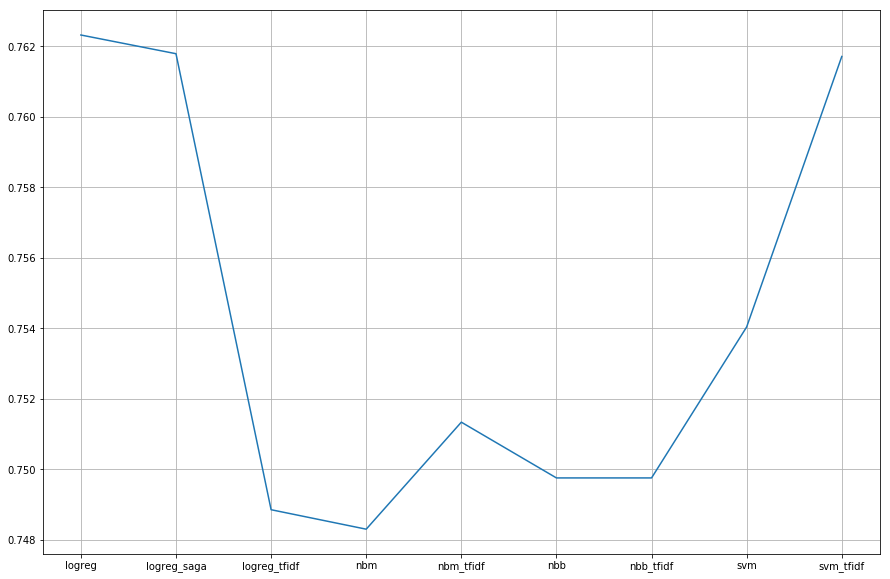

In [33]:
x = np.arange(9)
xticks = ['logreg', 'logreg_saga', 'logreg_tfidf', 'nbm', 'nbm_tfidf', 'nbb', 'nbb_tfidf', 'svm', 'svm_tfidf', ]

plt.figure(num=None, figsize=(15, 10))
plt.grid()
plt.xticks(x, xticks)
plt.plot(f1)
plt.show()

#### Сохраняем модель для дальнейшего использования

In [34]:
import gzip
f = gzip.open('model.pkl.gz', 'wb')
pickle.dump(model_logreg, f)
f.close()